In [1]:
# paramter cell do not remove!!
# nb_parm='datalake|raw/pdf|Birddiversityanddistribution|pdf||300|150'
# nb_parm='datalake|raw/text-csv|PFW_spp_translation_table_May2024|csv||300|150'
nb_parm='llmnok'
question = 'how many bird species are in migratory?'
embed_model = "mxbai-embed-large" 
gen_model = "deepseek-r1:7b"
# collection = "Bridknowledge"

In [2]:
import sys
import os

sys.path.append("/home/jovyan/notebooks")
from Framework.module import Utility

## Do the task after this

### Register model

In [3]:
from typing import List
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
import smtplib
from email.message import EmailMessage

llm = ChatOllama(
    model="llama3-groq-tool-use:8b",
    temperature=0,
    base_url="http://host.docker.internal:11434"
)

### define load_all_tools

In [4]:
import importlib
import inspect
from langchain_core.tools import tool
from importlib import import_module
from langchain_core.tools import BaseTool


def load_all_tools(module_path: str):
    """
    Load all @tool-decorated functions from a module.

    Args:
        module_path (str): Python module path like 'tools'

    Returns:
        List of tool function objects
    """
    tools = []
    module = import_module(module_path)
    for name, obj in inspect.getmembers(module):
        if isinstance(obj, BaseTool):
            tools.append(obj)
    return tools

### Load base tools to llm

In [5]:
from Framework import base_tools

# Augment the LLM with tools
basetools = load_all_tools("Framework.base_tools")
# tools_by_name = {tool.name: tool for tool in basetools}
llm_with_tools = llm.bind_tools(basetools)
for _ in basetools:
    print(f"load {_.name} successfully!")

load af_execute_to_oracle successfully!
load af_write_to_oracle successfully!
load connect_to_datalake successfully!
load connect_to_vecterdb successfully!
load read_file_from_datalake successfully!


### Intial pool of tools to vector db for future retrieval scability

In [6]:
from Framework import pool_of_tools
from datetime import datetime
import uuid
from weaviate.classes.config import Configure
from weaviate.classes.config import Property, DataType

def createCollection(client, collection):
    # if present
    if collection in client.collections.list_all():
        return client.collections.get(collection)

    # if not
    return client.collections.create(
        name=collection,
        vectorizer_config=Configure.Vectorizer.text2vec_ollama(
            api_endpoint=OLLAMA_API,
            model=embed_model
        ),
        generative_config=Configure.Generative.ollama(
            api_endpoint=OLLAMA_API,
            model=gen_model
        ),
        properties=[
            Property(name="tool_name", data_type=DataType.TEXT),
            Property(name="description", data_type=DataType.TEXT),
            Property(name="args_schema", data_type=DataType.TEXT),
            Property(name="func", data_type=DataType.TEXT),
            Property(name="source_id", data_type=DataType.TEXT),
            Property(name="timestamp", data_type=DataType.DATE)
        ]
    )
    
OLLAMA_API = "http://host.docker.internal:11434"
utility_tools = load_all_tools("Framework.pool_of_tools")
client = base_tools.connect_to_vecterdb.invoke("connect to vector db")
kb = createCollection(client, "Pool_Of_Tools")

result = kb.query.fetch_objects(limit=1000)
all_objects = result.objects 

existing_names = {obj.properties["tool_name"] for obj in all_objects}

for tool in utility_tools:
    if tool.name in existing_names:
        print(f"Skipping duplicate tool: {tool.name}")
        continue

    source_id = str(uuid.uuid4())
    timestamp = datetime.utcnow().replace(microsecond=0).isoformat() + "Z"

    kb.data.insert({
        "tool_name": tool.name,
        "description": tool.description,
        "args_schema": str(tool.args_schema),
        "func": tool.func.__name__,  # store function name only, not raw callable
        "source_id": source_id,
        "timestamp": timestamp
    })
    print(f"load {tool.name} successfully!")


client.close()

Skipping duplicate tool: add
Skipping duplicate tool: divide
Skipping duplicate tool: multiply
Skipping duplicate tool: send_google_email
Skipping duplicate tool: validate_user


In [7]:
# client = base_tools.connect_to_vecterdb.invoke("connect to vector db")
# print(client.collections.list_all())
# client.collections.delete("Pool_Of_Tools")
# client.close()

In [8]:
class CustomStore:
    def __init__(self, client, collection_name):
        self.client = client
        self.collection = client.collections.get(collection_name)

    def put(self, namespace, key, value):
        self.collection.data.insert({
            "tool_id": key,
            "description": value["description"]
        })

    def query(self, namespace, query_string, k=4):
        results = self.collection.query.near_text(query_string, limit=k)
        return [
            (obj.properties["tool_id"], {"score": obj.distance})
            for obj in results.objects
        ]


/tmp/ipykernel_7537/2761033876.py:28: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  embeddings = init_embeddings("ollama:mxbai-embed-large",


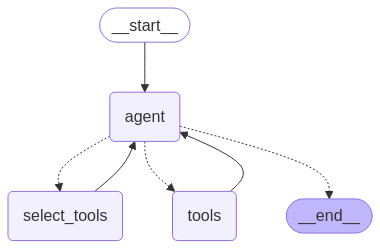

In [9]:
import math
import types
import uuid

from langchain.chat_models import init_chat_model
from langchain.embeddings import init_embeddings
from langgraph.store.memory import InMemoryStore

from langgraph_bigtool import create_agent
from langgraph_bigtool.utils import (
    convert_positional_only_function_to_tool
)

# retrieve tools from Pool_Of_Tools in weaviate
# client = base_tools.connect_to_vecterdb.invoke("connect to vector db")
# store = CustomStore(client, "Pool_Of_Tools")
# client.close()


        
# perform tools registry
utility_tools = load_all_tools("Framework.pool_of_tools")
tool_registry = {
    str(uuid.uuid4()): tool
    for tool in utility_tools
}

embeddings = init_embeddings("ollama:mxbai-embed-large",
                            temperature=0,
                            base_url="http://host.docker.internal:11434")

store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 1536,
        "fields": ["description"],
    }
)
for tool_id, tool in tool_registry.items():
    store.put(
        ("tools",),
        tool_id,
        {
            "description": f"tool_name:{tool.name}, description:{tool.description}, args_schema:{tool.args_schema}, func:{ tool.func}",
        },
    )
 
# Initialize agent
llm = init_chat_model(
                      #"ollama:llama3-groq-tool-use:8b", 
                      "ollama:PetrosStav/gemma3-tools:4b",
                      temperature=0,
                      base_url="http://host.docker.internal:11434")

builder = create_agent(llm, tool_registry)
agent = builder.compile(store=store)
agent



In [10]:
query = """Validate user 123 with these addresses:
            - 123 Fake st in Boston, MA
            - 234 Pretend Boulevard in Houston, TX
           Then keep the result
            
           Then send an email to nattapat.7140@gmail.com with:
            Subject: User Validation Result
            Body: Hi Best, here validation result {result}
            Sender: nattapat.0645@gmail.com
            Password: a0645402317 
            If cannot send email end the task
         """
# Test it out
for step in agent.stream(
    {"messages": query},
    stream_mode="updates",
):
    for _, update in step.items():
        for message in update.get("messages", []):
            message.pretty_print()

KeyboardInterrupt: 

In [ ]:
# # Fetch all objects from the Pool_Of_Tools collection (kb)
# client = base_tools.connect_to_vecterdb.invoke("connect to vector db")
# kb = createCollection(client, "Pool_Of_Tools")

# result = kb.query.fetch_objects(limit=1000)
# all_objects = result.objects 

 
# # Print each object in a readable format
# for obj in all_objects:
#     print("----- Tool Record -----")
#     for key, value in obj.properties.items():
#         print(f"{key}: {value}")
#     print()

# client.close()

In [ ]:
from Framework import pool_of_tools

# result = pool_of_tools.multiply.invoke({"a": 2, "b": 6})
# print(result)

# result = all_tools[0].invoke({"a": 2, "b": 6})
# print(result)

# all_tools[0] has same type with pool_of_tools.multiply